# CIFAR-10 Autoencoder

**Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

**Load and prepare the dataset**


In [3]:
# Preprocessing function
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image 

# Parameters
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load("cifar10", split="train", as_supervised=True)
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tfds.load("cifar10", split="test", as_supervised=True)
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteTTOWH2/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteTTOWH2/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
for im, im2 in train_dataset.take(1):
  print(im.shape, im2.shape)

(128, 32, 32, 3) (128, 32, 32, 3)


**Build the Model**

In [6]:
tf.keras.backend.clear_session()

input=tf.keras.Input(shape=(32,32,3))

encoder=tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(input)
encoder=tf.keras.layers.MaxPooling2D((2,2))(encoder)
encoder=tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(encoder)
encoder=tf.keras.layers.MaxPooling2D((2,2))(encoder)

bottleneck=tf.keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(encoder)
encoder_display=tf.keras.layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(bottleneck)

decoder=tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(bottleneck)
decoder=tf.keras.layers.UpSampling2D((2,2))(decoder)
decoder=tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(decoder)
decoder=tf.keras.layers.UpSampling2D((2,2))(decoder)
decoder=tf.keras.layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(decoder)

model=tf.keras.Model(inputs=input, outputs=decoder)
encoder_model=tf.keras.Model(inputs=input, outputs=encoder_display)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168

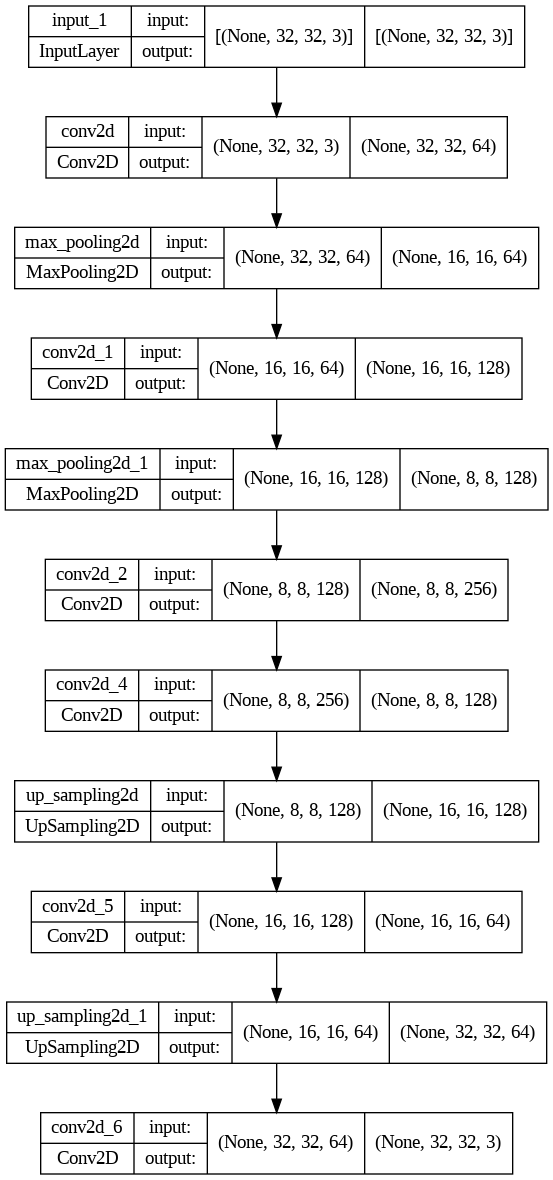

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

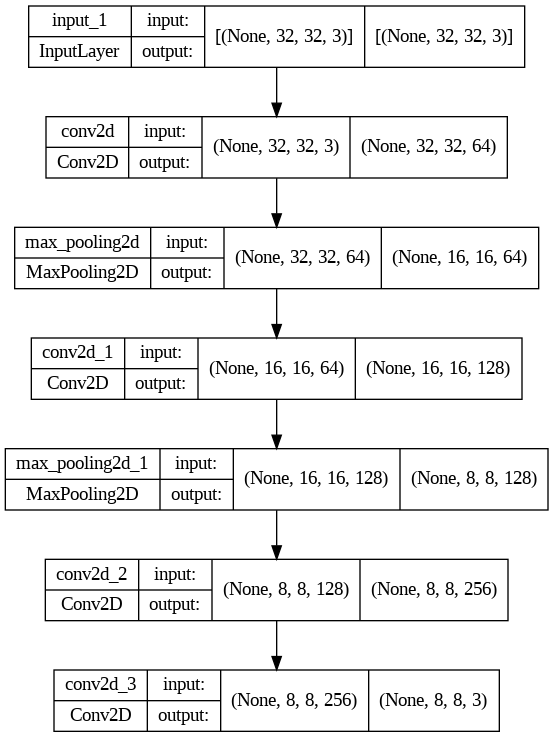

In [8]:
tf.keras.utils.plot_model(encoder_model, show_shapes=True, show_layer_names=True)

**Training Model**

In [9]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

In [10]:
train_steps = len(train_dataset) // BATCH_SIZE
val_steps = len(test_dataset) // BATCH_SIZE

model.fit(train_dataset, epochs=10, validation_data=test_dataset, verbose=2)

Epoch 1/10
391/391 - 18s - loss: 0.0093 - accuracy: 0.7421 - val_loss: 0.0049 - val_accuracy: 0.8016 - 18s/epoch - 46ms/step
Epoch 2/10
391/391 - 10s - loss: 0.0040 - accuracy: 0.8082 - val_loss: 0.0035 - val_accuracy: 0.8215 - 10s/epoch - 27ms/step
Epoch 3/10
391/391 - 10s - loss: 0.0032 - accuracy: 0.8196 - val_loss: 0.0030 - val_accuracy: 0.7947 - 10s/epoch - 26ms/step
Epoch 4/10
391/391 - 10s - loss: 0.0027 - accuracy: 0.8199 - val_loss: 0.0024 - val_accuracy: 0.8291 - 10s/epoch - 27ms/step
Epoch 5/10
391/391 - 10s - loss: 0.0024 - accuracy: 0.8240 - val_loss: 0.0021 - val_accuracy: 0.8370 - 10s/epoch - 25ms/step
Epoch 6/10
391/391 - 10s - loss: 0.0021 - accuracy: 0.8268 - val_loss: 0.0020 - val_accuracy: 0.8302 - 10s/epoch - 26ms/step
Epoch 7/10
391/391 - 10s - loss: 0.0021 - accuracy: 0.8241 - val_loss: 0.0019 - val_accuracy: 0.8384 - 10s/epoch - 27ms/step
Epoch 8/10
391/391 - 10s - loss: 0.0018 - accuracy: 0.8344 - val_loss: 0.0017 - val_accuracy: 0.8193 - 10s/epoch - 26ms/step


**Model evaluation**

In [11]:
result = model.evaluate(test_dataset, steps=10)

10/10 [==============================] - 0s 14ms/step - loss: 0.0015 - accuracy: 0.8290


In [65]:
def extract_feature(data):
  data=data.unbatch()
  images=[]

  for image, image2 in data:
    images.append(image.numpy())

  return np.array(images)


def display_images(images, images_pred, encoders_pred, num_blocks=1, random=True):
  num_cols=10
  len_data=len(images)
  num_images=num_blocks*num_cols

  if random:
    indexes=np.random.choice(len_data, size=num_images)
  else:
    indexes=np.arange(num_images)

  for j in range(num_blocks):
    fig, ax = plt.subplots(3, num_cols, figsize=(15, 5))

    for i in range(num_cols):
      image=images[indexes[i+num_cols*j]]
      image_pred=images_pred[indexes[i+num_cols*j]]
      encoder=encoders_pred[indexes[i+num_cols*j]]

      ax[0,i].imshow(image)
      ax[0,i].axis("off")
      ax[1,i].imshow(encoder)
      ax[1,i].axis("off")
      ax[2,i].imshow(image_pred)
      ax[2,i].axis("off")

    plt.show()
    print("*"*155)

In [38]:
images=extract_feature(test_dataset)

In [47]:
images.shape

(10000, 32, 32, 3)

In [40]:
encoders_pred=encoder_model.predict(images, batch_size=BATCH_SIZE, verbose=0)
images_pred=model.predict(images, batch_size=BATCH_SIZE, verbose=0)

In [42]:
images_pred.shape, encoders_pred.shape

((10000, 32, 32, 3), (10000, 8, 8, 3))

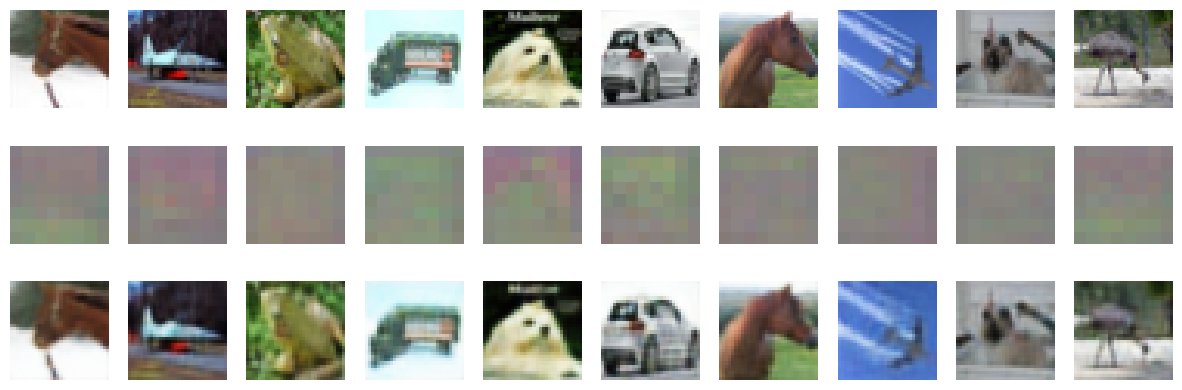

***********************************************************************************************************************************************************


In [68]:
display_images(images, images_pred, encoders_pred, num_blocks=1, random=False)

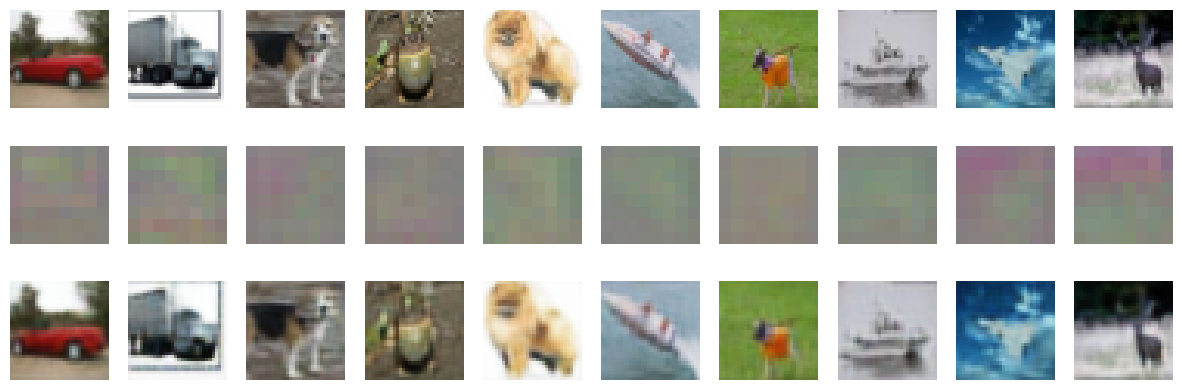

***********************************************************************************************************************************************************


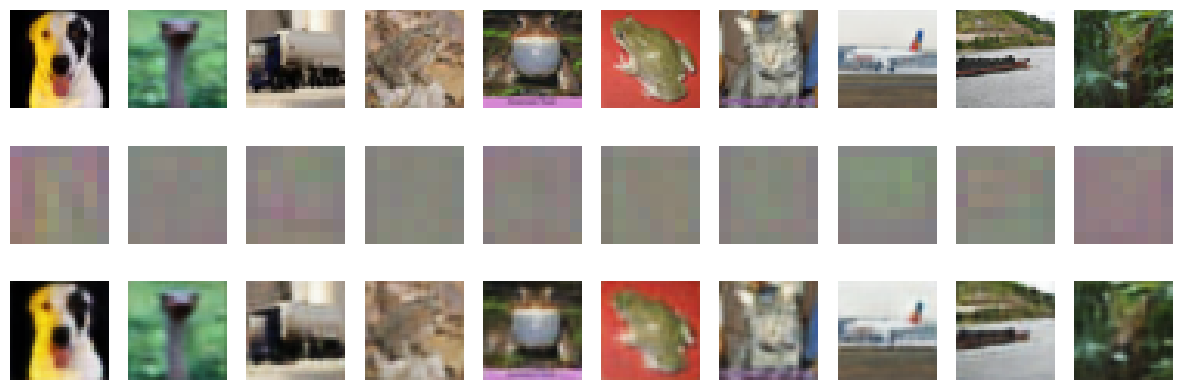

***********************************************************************************************************************************************************


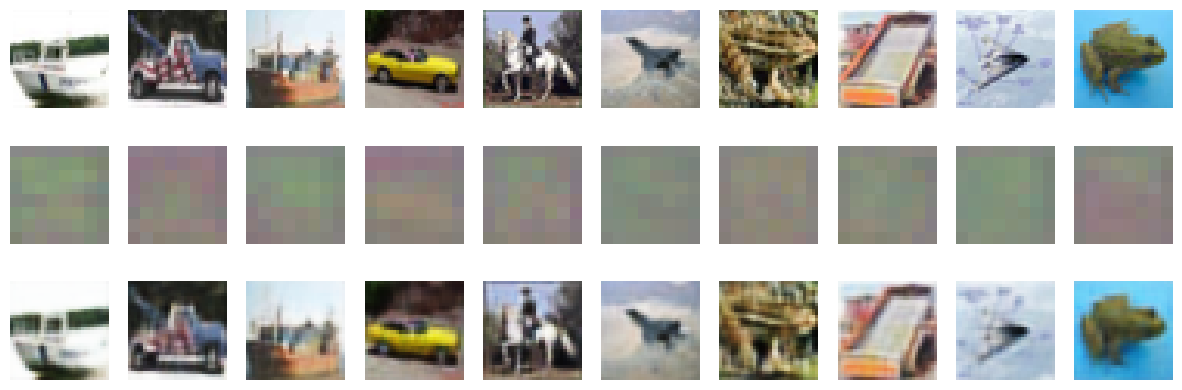

***********************************************************************************************************************************************************


In [70]:
display_images(images, images_pred, encoders_pred, num_blocks=3)